# PROJECT: Telco Customer Churn Prediction 
# Goal: Predict which customers will leave the company (Churn) and identify the key drivers to improve retention.

## 1. Environment Setup
Importing essential libraries for data manipulation (Pandas), visualization (Seaborn/Matplotlib), and machine learning (Scikit-Learn/XGBoost).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import shap
import sqlite3
import warnings
warnings.filterwarnings('ignore')

## 2. Loading the Dataset
Reading the customer churn dataset. Displaying the first few rows and checking data types to identify any initial data quality issues.

In [3]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

display(df.head())
df.info()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 3. Data Cleaning & Preprocessing
Converting 'TotalCharges' to numeric format and handling missing values. We also map the target variable 'Churn' to binary format (1 for Yes, 0 for No) to make it compatible with machine learning algorithms.

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.dropna(subset=['TotalCharges'], inplace=True)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("Data Cleaning Complete.")

Data Cleaning Complete.


## 4. Exploratory Data Analysis (EDA)
Visualizing key business metrics. We examine the overall churn rate, the impact of contract types, and the correlation between numerical features. 

**Key Insight:** Month-to-month contracts show significantly higher churn.

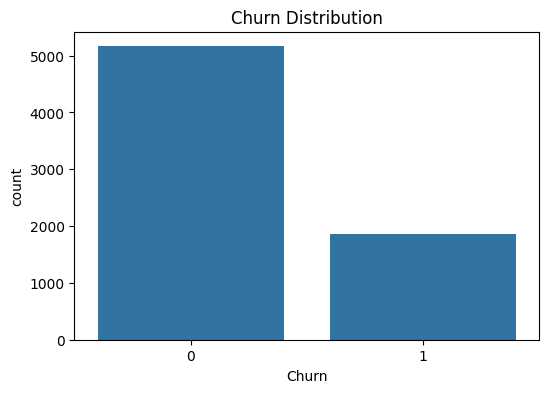

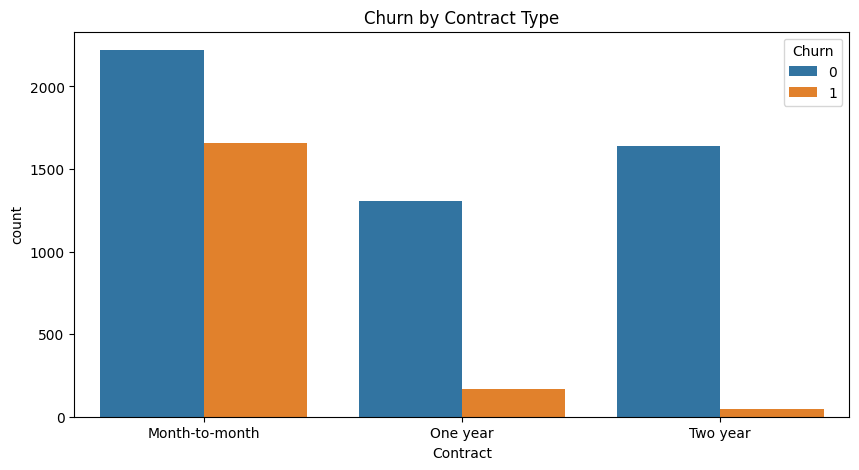

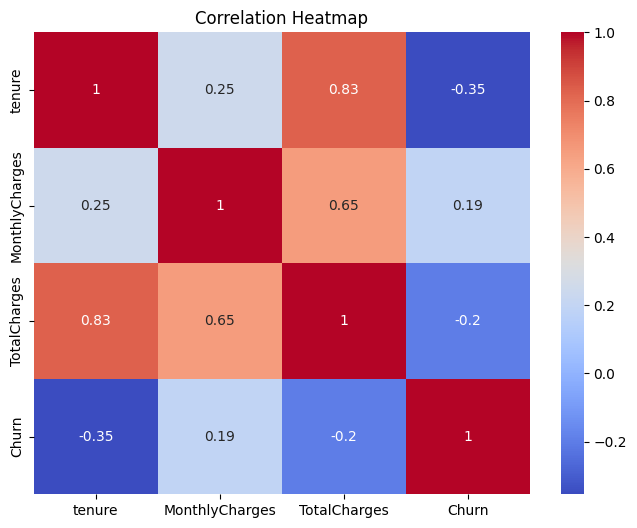

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Churn by Contract Type')
plt.show()

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
plt.figure(figsize=(8,6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 5. Feature Engineering & Train-Test Split
Preparing the data for modeling. This involves:
1. Splitting data into Training and Testing sets.
2. Scaling numerical features and One-Hot Encoding categorical variables.
3. Applying **SMOTE** to handle class imbalance.

In [6]:
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

print(f"Training Data Shape: {X_train_resampled.shape}")
print(f"Testing Data Shape: {X_test_transformed.shape}")

Training Data Shape: (8260, 44)
Testing Data Shape: (1407, 44)


## 6. Model Training & Baseline Evaluation
Training three different models: Logistic Regression, Random Forest, and XGBoost. We evaluate them based on **Recall** (sensitivity) because identifying potential churners is the primary business objective.

In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_transformed)
    
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

--- Logistic Regression ---
Accuracy: 0.7285
ROC-AUC: 0.7435
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.78      0.60       374

    accuracy                           0.73      1407
   macro avg       0.70      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407

--- Random Forest ---
Accuracy: 0.7619
ROC-AUC: 0.6988
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1033
           1       0.55      0.56      0.56       374

    accuracy                           0.76      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.76      0.76      0.76      1407

--- XGBoost ---
Accuracy: 0.7711
ROC-AUC: 0.7188
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1033
           1       0.56      0.61      0.59       374

    accuracy     

## 7. Hyperparameter Tuning (XGBoost)
Optimizing the XGBoost model using `RandomizedSearchCV`. We prioritize **Recall** (using `scale_pos_weight`) to ensure we catch the maximum number of at-risk customers.

In [8]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 3, 5]
}

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

search = RandomizedSearchCV(
    xgb_model,
    param_grid,
    scoring='recall',
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_resampled, y_train_resampled)

final_model = search.best_estimator_
y_pred_final = final_model.predict(X_test_transformed)

print("--- Final Optimized XGBoost ---")
print(classification_report(y_test, y_pred_final))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
--- Final Optimized XGBoost ---
              precision    recall  f1-score   support

           0       0.97      0.41      0.58      1033
           1       0.37      0.96      0.54       374

    accuracy                           0.56      1407
   macro avg       0.67      0.69      0.56      1407
weighted avg       0.81      0.56      0.57      1407



## 8. Model Interpretation (SHAP Values)
Using SHAP (SHapley Additive exPlanations) to understand the 'Why' behind predictions. This plot reveals the top drivers of churn.

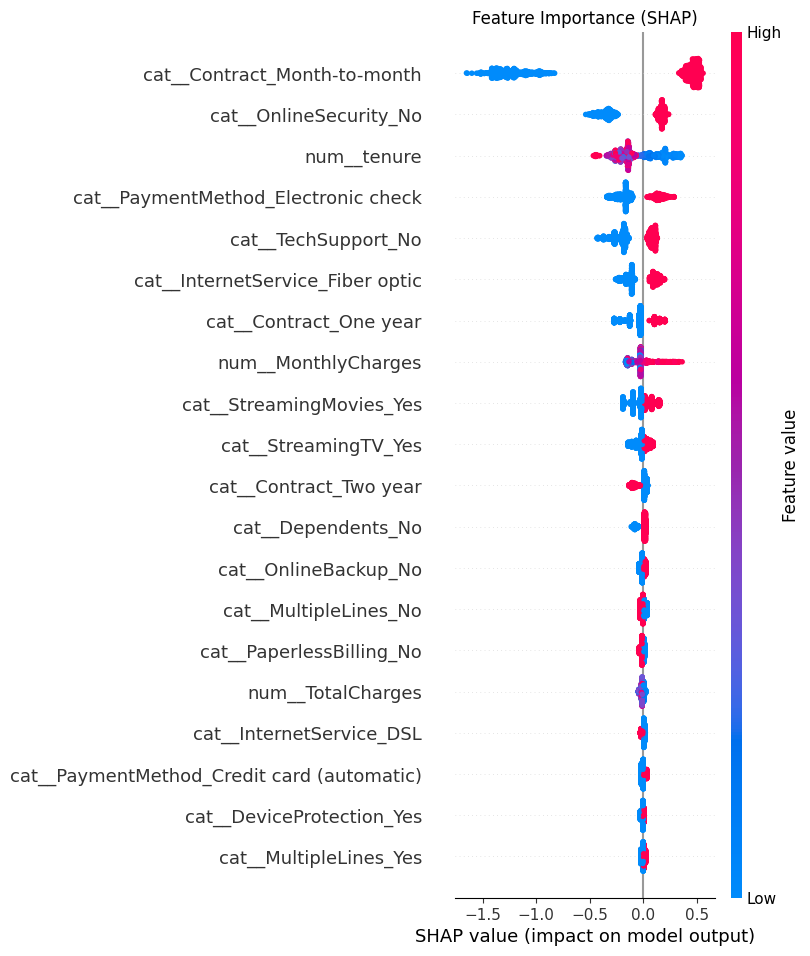

In [9]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_transformed)

feature_names_raw = preprocessor.get_feature_names_out()

clean_feature_names = {
    'cat_Contract_Month-to-month': 'Contract: Month-to-Month',
    'cat_OnlineSecurity_No': 'No Online Security',
    'num_tenure': 'Tenure',
    'cat_PaymentMethod_Electronic check': 'Payment: Electronic Check',
    'cat_TechSupport_No': 'No Tech Support',
    'cat_InternetService_Fiber optic': 'Internet: Fiber Optic',
    'cat_Contract_One year': 'Contract: One Year',
    'num_MonthlyCharges': 'Monthly Charges',
    'num_TotalCharges': 'Total Charges'
}

mapped_feature_names = [clean_feature_names.get(name, name) for name in feature_names_raw]

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_transformed, feature_names=mapped_feature_names, show=False)
plt.title('Feature Importance (SHAP)')
plt.show()

## 9. SQL Data Analysis
Simulating a database environment to run SQL queries. We calculate specific churn rates by contract type and identify high-value customers who are at risk of leaving.

In [10]:
conn = sqlite3.connect(':memory:')
df.to_sql('churn_data', conn, index=False, if_exists='replace')

query1 = """
SELECT 
    Contract, 
    COUNT(customerID) as Total_Customers,
    SUM(Churn) as Total_Churned,
    ROUND(CAST(SUM(Churn) AS FLOAT) / COUNT(customerID) * 100, 2) as Churn_Rate_Percent
FROM churn_data
GROUP BY Contract
ORDER BY Churn_Rate_Percent DESC;
"""

print("--- Churn Rate by Contract ---")
print(pd.read_sql(query1, conn))

query2 = """
SELECT customerID, MonthlyCharges, tenure
FROM churn_data
WHERE Churn = 1 
AND MonthlyCharges > 70 
AND tenure < 12
LIMIT 5;
"""

print("\n--- High Value At-Risk Customers ---")
print(pd.read_sql(query2, conn))

--- Churn Rate by Contract ---
         Contract  Total_Customers  Total_Churned  Churn_Rate_Percent
0  Month-to-month             3875           1655               42.71
1        One year             1472            166               11.28
2        Two year             1685             48                2.85

--- High Value At-Risk Customers ---
   customerID  MonthlyCharges  tenure
0  9237-HQITU           70.70       2
1  9305-CDSKC           99.65       8
2  8168-UQWWF           97.85      11
3  7760-OYPDY           80.65       2
4  7495-OOKFY           80.65       8


## 10. Exporting Data for Power BI
Saving the cleaned and processed dataset as a CSV file. This file will be used to build the interactive Power BI dashboard for stakeholders.

In [11]:
df.to_csv('../data/churn_dashboard_data.csv', index=False)
print("File saved successfully to ../data/churn_dashboard_data.csv")

File saved successfully to ../data/churn_dashboard_data.csv
